pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
2.7.0
64 64 3
1.0 0.0 0.18713235294117647


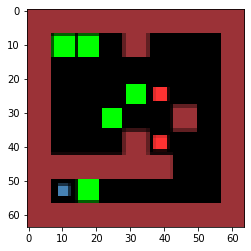

In [1]:
import random
import time
from game import Game
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print(tf.__version__)

env = Game(30)
env.init()

height, width, channels = env.state().shape
actions = 4

print(height, width, channels)

imgdata = env.state()
plt.imshow(imgdata)
print(np.max(imgdata), np.min(imgdata), np.average(imgdata))
plt.show()
env.close()

In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

In [3]:
class GameEnv(Env):
    def __init__(self):
        # Actions we can take, left, right, up, down
        self.start_time = 150
        self.action_space = Discrete(4)
        
        self.game = Game(30)
        self.game.init()
        
        shape = self.game.state().shape
        # picture array
        self.observation_space = Box(low=np.zeros(shape), high=np.ones(shape))
        # Set start temp
        self.state = self.game.state()
        # Game length
        self.time_left = self.start_time
        
    def step(self, action):
        self.state, reward, done = self.game.step(action)
        self.time_left -= 1
        # Check if shower is done
        if self.time_left <= 0: 
            done = True
        elif not done:
            done = False
        
        # Apply temperature noise
        #self.state += random.randint(-1,1)
        # Set placeholder for info
        info = {}
        
        # Return step information
        return self.state, reward, done, info

    def render(self):
        self.game.visualize()
    
    def reset(self):
        self.game.init()
        self.state = self.game.state()
        self.time_left = self.start_time
        return self.state
    
    def close(self):
        self.game.close()

In [4]:
env = GameEnv()
np.shape(env.observation_space.sample())

C:\Users\Michael\Anaconda3\envs\reinforcment_rl\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


(64, 64, 3)

In [5]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    frames = 0
    while not done:
        env.render()
        time.sleep(0.1)
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

Episode:1 Score:3.6000000000000014
Episode:2 Score:0.5549999999999998
Episode:3 Score:0.4999999999999999
Episode:4 Score:-0.355
Episode:5 Score:-0.3


In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam

In [4]:
def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(3,height, width, channels)))
    model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [5]:
model = build_model(height, width, channels, actions)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 15, 15, 32)     6176      
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 6, 6, 64)       32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 4, 4, 64)       36928     
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 4)                 1

In [6]:
from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

In [7]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit=1000, window_length=3)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=1000
                  )
    return dqn

In [8]:
def setup_gpus():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.experimental.set_visible_devices(gpus[0],'GPU')
            tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1500)])
        except RuntimeError as e:
            print(e)
            
setup_gpus()

Virtual devices cannot be modified after being initialized


In [9]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-4))
print("kek")